# (Efficient) Spherical Harmonic Transform

## Preliminaries

### Spherical harmonics transform

The truncated series expansion of a function $f$ defined on the surface of a sphere can be written as

$$
f(\theta, \lambda) = \sum_{m=-M}^{M} \exp(im\lambda) \sum_{n=|m|}^{M} F_n^m \bar{P}_n^m (\cos \theta),
$$

where $\theta$ is the colatitude, $\lambda$ the longitude, $\bar{P}_n^m$ the normalized, associated Legendre polynomials and $F_n^m$, the expansion coefficient associated to the mode $(m,n)$.

A direct spherical harmonic transform can be accomplished by a Fourier transform

$$
F^m(\theta) = \frac{1}{2 \pi} \int_{0}^{2\pi} f(\theta, \lambda) \exp(-im\lambda) \; \mathrm{d}\lambda
$$

in longitude and a Legendre transform

$$
F_n^m = \frac{1}{2} \int_{-1}^1 F^m(\theta) \bar{P}_n^m(\cos \theta) \; \mathrm{d} \cos \theta
$$

in latitude.

## Usage

### Preparation

Let us begin by loading some libraries that we will be needing:

In [1]:
import paddle
import paddle.nn as nn
import paddle.fft as fft
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")

cmap = 'turbo'

We should also load the `sht`:

In [2]:
from paddle_harmonics import *

If a GPU is available we want to use it:

In [3]:
device = paddle.CUDAPlace(0) if paddle.device.cuda.device_count() > 0 else paddle.CPUPLace()

### Test data

Let us load some test-data in 2D for testing. We use the MOLA digital elevation map of MARS, courtesy of NASA:

In [4]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

--2024-11-06 10:22:10--  https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg
Resolving astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)... 137.227.239.81, 2001:49c8:c000:122d::81
Connecting to astropedia.astrogeology.usgs.gov (astropedia.astrogeology.usgs.gov)|137.227.239.81|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 55192 (54K) [image/jpeg]
Saving to: ‘./data/mola_topo.jpg’

./data/mola_topo.jp 100%[===================>]  53.90K   123KB/s    in 0.4s    

2024-11-06 10:22:12 (123 KB/s) - ‘./data/mola_topo.jpg’ saved [55192/55192]



Let us load and visualize the data:

In [5]:
import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(paddle.to_tensor(data).unsqueeze(0).unsqueeze(0), size=(512,1024)).squeeze()

W1106 10:22:12.937942 184986 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.3, Runtime API Version: 12.4
W1106 10:22:12.938583 184986 gpu_resources.cc:164] device: 0, cuDNN Version: 9.4.


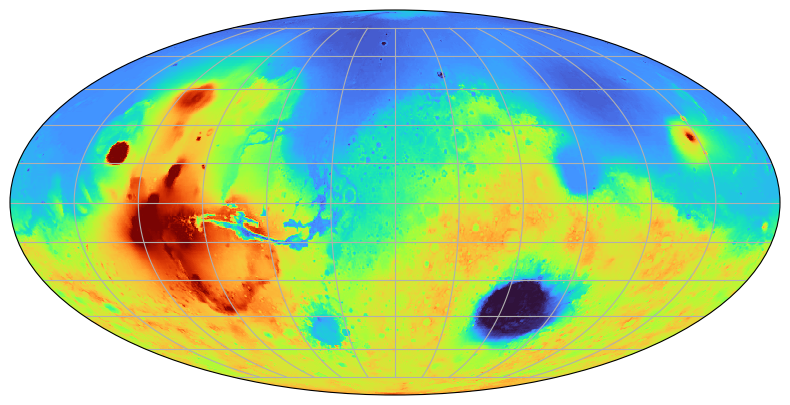

In [6]:
n_theta = data.shape[0]
n_lambda = data.shape[1]
lon = np.linspace(-np.pi, np.pi, n_lambda)
lat = np.linspace(np.pi/2., -np.pi/2., n_theta)
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, data, cmap=cmap)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

We want the data on the GPU. Moreover, `torch_harmonics` expects the last two dimensions to be the spatial dimensions. To this end, we permute the data:

In [7]:
signal = data.to(device)

### Spherical Harmonic Transform:

To allow for composability, `torch_harmonics` provides it's transform in the form of PyTorch NN modules. As such we begin by initializing them:

In [8]:
sht = RealSHT(n_theta, n_lambda, grid="equiangular").to(device)
isht = InverseRealSHT(n_theta, n_lambda, grid="equiangular").to(device)

In [9]:
coeffs = sht(signal)

Let us plot the logarithm of the absolute coefficients:

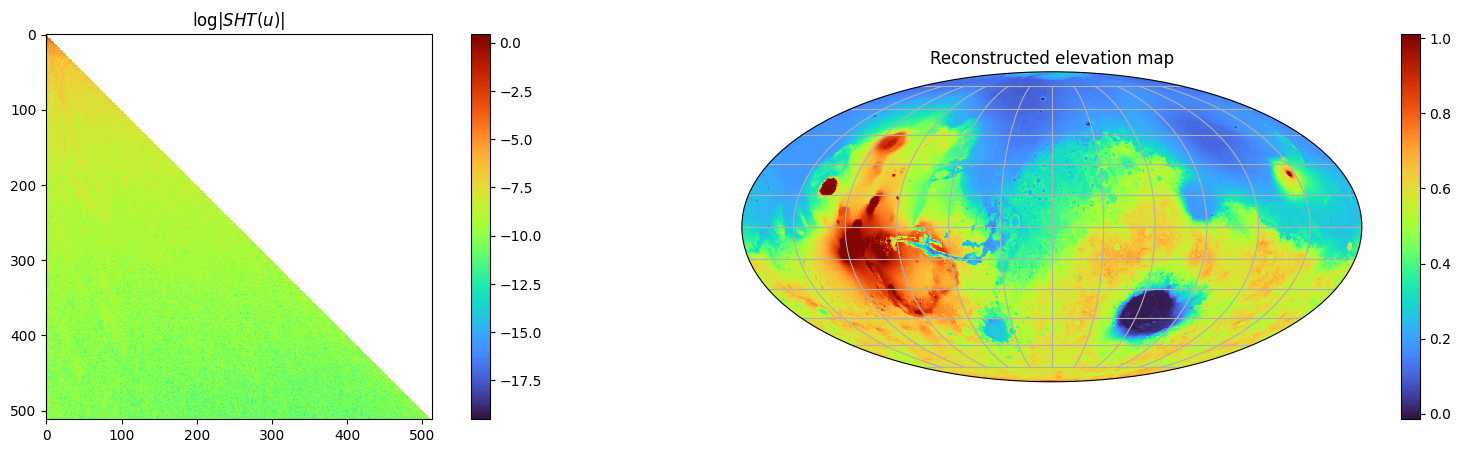

In [10]:
fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 2, 1)
plt.imshow(coeffs.abs().log().cpu(), cmap=cmap)
plt.title("$\log | SHT(u) |$")
plt.colorbar()

ax = fig.add_subplot(1, 2, 2, projection='mollweide')
plt.pcolormesh(Lon, Lat, isht(coeffs).cpu(), cmap=cmap)
ax.set_title("Reconstructed elevation map")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar()
plt.show()

We can transform the the solution back and plot the error:

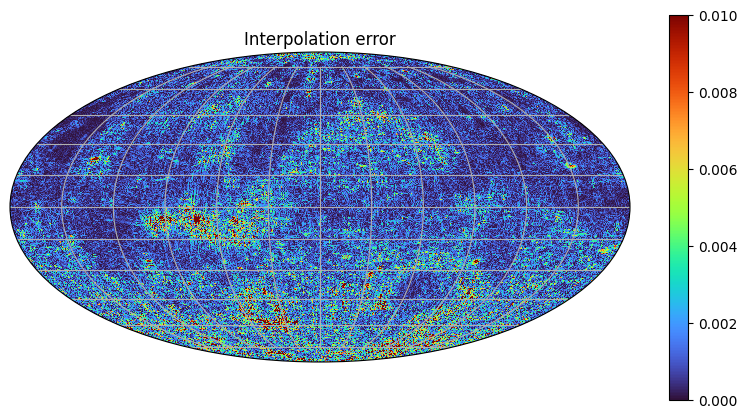

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (isht(coeffs).cpu() - data).abs(), cmap=cmap, vmin=0, vmax=0.01)
ax.set_title("Interpolation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

### Differentiability

`torch_harmonics` is differentiable, so let's use this functionality. We can perform a simple fit of spectral coefficients by using a simple model which will use 100 modes to approximate our original model:

In [12]:
class SpectralModel(nn.Layer):
    def __init__(self, n_modes, out_dims):
        super().__init__()
        coeffs = paddle.randn([n_modes, n_modes+1], dtype=paddle.complex128).as_real()
        self.coeffs = paddle.create_parameter(shape=coeffs.shape, dtype=coeffs.dtype, default_initializer=paddle.nn.initializer.Assign(coeffs))
        self.isht = InverseRealSHT(out_dims[0], out_dims[1], lmax=n_modes, mmax=n_modes+1, grid="equiangular").to(device)

    def forward(self):
        return self.isht(self.coeffs.as_complex())

sh_model = SpectralModel(120, (n_theta, n_lambda)).to(device)
sh_model

SpectralModel(
  (isht): InverseRealSHT(
    nlat=512, nlon=1024,
     lmax=120, mmax=121,
     grid=equiangular, csphase=True
  )
)

and now, let us train the model

In [13]:
optimizer = paddle.optimizer.Adam(parameters = sh_model.parameters(), learning_rate = 5e-2)

for iter in range(500):

    loss = (sh_model() - signal).pow(2).mean()

    optimizer.clear_grad()
    loss.backward()
    optimizer.step()

    if iter % 10 == 0:
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 1090.6009950589037
iteration: 10 loss: 309.4880655590983
iteration: 20 loss: 94.71263656602319
iteration: 30 loss: 31.49942572403521
iteration: 40 loss: 11.079884366911308
iteration: 50 loss: 4.030517524754031
iteration: 60 loss: 1.4530727759481046
iteration: 70 loss: 0.5464418218846278
iteration: 80 loss: 0.20826875566140304
iteration: 90 loss: 0.07938524816112295
iteration: 100 loss: 0.030936051734637218
iteration: 110 loss: 0.012579492989447414
iteration: 120 loss: 0.005371598234062838
iteration: 130 loss: 0.0023894411507696216
iteration: 140 loss: 0.0011335206207822022
iteration: 150 loss: 0.0006320873373741602
iteration: 160 loss: 0.00042183717184209193
iteration: 170 loss: 0.00034825737596623756
iteration: 180 loss: 0.00031286782161213595
iteration: 190 loss: 0.0003014873278817305
iteration: 200 loss: 0.0002983585258582059
iteration: 210 loss: 0.00029739971989474885
iteration: 220 loss: 0.00029709908841539013
iteration: 230 loss: 0.00029700604557256313
iteratio

let us plot the approximation:

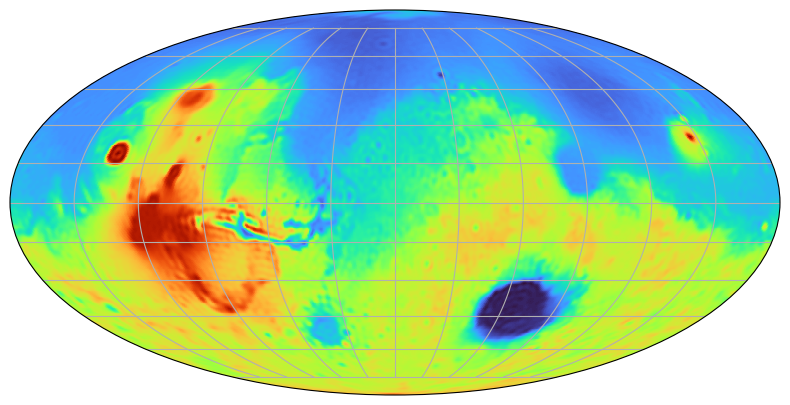

In [14]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
ax.pcolormesh(Lon, Lat, sh_model().detach().cpu(), cmap=cmap)
# ax.set_title("Elevation map of mars")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.show()

Not bad! Let us again plot the error:

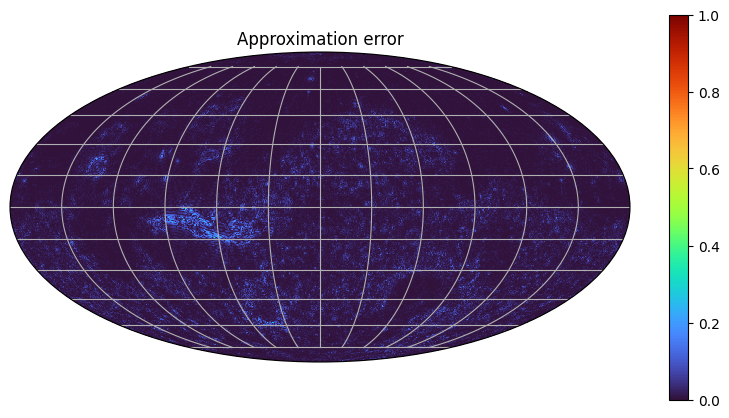

In [15]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
img = ax.pcolormesh(Lon, Lat, (sh_model().detach() - signal).abs().cpu(), cmap=cmap, vmin=0, vmax=1)
ax.set_title("Approximation error")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.colorbar(img, ax=ax)
plt.show()

## Conclusion

This concludes our introduction to `torch-harmonics`. If you are enjoying this library, make sure to cite us: